In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import hypll
from hypll.manifolds.poincare_ball import Curvature, PoincareBall
from hypll.optim import RiemannianAdam
import hypll.nn as hnn
from hypll.tensors import TangentTensor
from matplotlib.animation import FuncAnimation
import argparse
from pyramid import create_pyramid
from continuous_maze import get_maze_image, bfs, gen_traj, plot_traj, ContinuousGridEnvironment, TrajectoryDataset, TrajectoryImageDataset, LabelDataset
from hyperbolic_networks import HyperbolicMLP, hyperbolic_infoNCE_loss, manifold_map
from networks import StateActionEncoder, StateEncoder, infoNCE_loss, FlexibleCNN, ActionNetwork
import os

import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"

def evaluate(maze, num_trials, encoder1, encoder2, manifold, image_height, image_width, max_steps=100, hyperbolic=False, eps=10., step_size=0.5, verbose=False):
    valid_indices = np.argwhere(maze == 0)
    np.random.shuffle(valid_indices)
    
    results = []
    for i in range(num_trials):
        with torch.no_grad():
            start, end = np.random.randint(0, len(valid_indices), size=2)
            start = tuple(valid_indices[start])
            end = tuple(valid_indices[end])
            
            goal = torch.tensor(get_maze_image(maze, end, image_height, image_width)).to(device, torch.float32).unsqueeze(0)
            # plt.imshow(goal)[0]
            goal = encoder2(goal)
            
            env = ContinuousGridEnvironment(maze, start, {})
            
            def reached(cur_pos, goal_pos):
                # print(f'cur pos: {cur_pos}')
                cur_pos = (int(cur_pos[0]), int(cur_pos[1]))
                goal_pos = (int(goal_pos[0]), int(goal_pos[1]))
                return cur_pos == goal_pos
            
            def step():
                cur_pos = env.agent_position
                if verbose:
                    print(f'cur_pos: {cur_pos}, goal: {goal}')
                image = torch.tensor(get_maze_image(maze, cur_pos, image_height, image_width)).to(device, torch.float32). unsqueeze(0)
                activations = []
                angles = torch.linspace(0., 2 * torch.pi, 16)
                for a in angles:
                    action = torch.tensor([torch.sin(a), torch.cos(a)]).unsqueeze(0).to(device, torch.float32)
                    # cur = torch.tensor([torch.sin(a), torch.cos(a)]).to(device, torch.float32)
                    # if hyperbolic:
                    #     cur = manifold_map(cur, manifold)
                    # print(f'action: {action}')
                    cur = encoder1(image, action) # YOU CAN OPTIMIZE THIS
                    # print(f'encoded: {cur.shape}')

                    # MANIFOLD EVAL
                    if hyperbolic:
                        activations.append((action, -manifold.dist(x=cur, y=goal)))
                    else:
                        activations.append((action, -torch.norm(cur - goal)))
                        

                best_action = activations[np.argmax([x[1].cpu() for x in activations])][0][0].cpu()
                # print(f'best action: {best_action}')
                angle = np.arctan2(best_action[0], best_action[1]) + np.random.normal() * eps * (2 * np.pi / 360)
                best_action = torch.tensor(np.array([np.sin(angle), np.cos(angle)]))
                env.move_agent(best_action)
                # print(f'agent position: {env.agent_position}')
                
                
            def SPL(maze, start, end, num_steps, success): # Success weighted by (normalized inverse) Path Length
                if not success:
                    return 0
                else:
                    p = num_steps * step_size
                    l = len(bfs(maze, start, end))
                    return (l / max(p, l))
            
            steps = 0
            while not reached(env.agent_position, end):
                if steps > max_steps:
                    break
                step()
                steps += 1
                
            result = (not reached(env.agent_position, end), steps, SPL(maze, start, end, steps, reached(env.agent_position, end)))
            if verbose:
                print(reached(env.agent_position, end))
                print(f'start: {start}, goal: {end}, end_pos: {env.agent_position}, steps: {steps}')
                print(results)
                
            results.append(result)
    
    return results


def save_models(encoder1, encoder2, best_encoder1, best_encoder2, epoch, best_epoch, name=''):
    os.makedirs('models', exist_ok=True)
    torch.save(encoder1.state_dict(), f'models/{name}_encoder1_epoch_{epoch}.pth')
    torch.save(encoder2.state_dict(), f'models/{name}_encoder2_epoch_{epoch}.pth')
    torch.save(best_encoder1.state_dict(), f'models/{name}_best_encoder1_epoch_{best_epoch}.pth')
    torch.save(best_encoder2.state_dict(), f'models/{name}_best_encoder2_epoch_{best_epoch}.pth')



In [7]:
print(device)

cuda


In [10]:
# maze = create_pyramid(np.zeros((2, 2)), 1)[0]
maze = np.zeros((10, 10))
# wandb.init(
#     project="testing", 
#     name='blah', 
#     # Track hyperparameters and run metadata
#     config={
#         "batch_size": 32,
#         "embedding_dim": 8,
#         "eval_trials": 100,
#         "max_steps": 100,
#         "hyperbolic": False,
#         "num_epochs": 8,
#         "temperature": 0.1,
#         "num_negatives": 11,
#         "learning_rate": 0.001,
#         "architecture": "MLP",
#         "maze": maze,
#         "num_trajectories": 10000,
#         "maze_type": 'blank'
#     }
# )

class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config={
    "batch_size": 32,
    "embedding_dim": 8,
    "eval_trials": 5,
    "max_steps": 100,
    "hyperbolic": False,
    "num_epochs": 24,
    "temperature": 0.1,
    "num_negatives": 11,
    "learning_rate": 0.001,
    "architecture": "MLP",
    "maze": maze,
    "num_trajectories": 100,
    "maze_type": 'blank',
    "image_height": 128,
    "image_width": 128
}
config = Config(config)

manifold = PoincareBall(c=Curvature(value=0.1, requires_grad=True))

dataset = TrajectoryImageDataset(maze, config.num_trajectories, embedding_dim=config.embedding_dim, num_negatives=10, image_height=config.image_height, image_width=config.image_width)
# plt.imshow(dataset[0][1])
# print('here')
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, num_workers=1)

# if config.hyperbolic:
#     encoder1 = HyperbolicMLP(in_features=4, out_features=config.embedding_dim, manifold=manifold.to(device)).to(device)
#     encoder2 = HyperbolicMLP(in_features=2, out_features=config.embedding_dim, manifold=manifold.to(device)).to(device)
#     optimizer = RiemannianAdam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=config.learning_rate)
# else:
#     encoder1 = StateActionEncoder(config.embedding_dim).to(device)
#     encoder2 = StateEncoder(config.embedding_dim).to(device)
#     optimizer = optim.Adam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=config.learning_rate)


    
encoder2 = FlexibleCNN(3, config.embedding_dim, np.zeros((1, 3, config.image_height, config.image_width))).to(device)
encoder1 = ActionNetwork(encoder2, config.embedding_dim).to(device)
optimizer = optim.Adam(list(encoder1.parameters()) + list(encoder2.parameters()), lr=config.learning_rate)
    
best_spl = 0
best_encoder1 = encoder1.state_dict()
best_encoder2 = encoder2.state_dict()
best_epoch = 0

# Training loop
for epoch in range(config.num_epochs):
    total_loss = 0
    for anchor, positive, negatives in dataloader:
        # (s,a) <-> (s)
        anchor = torch.tensor(anchor).to(device, torch.float32) # 4 vector
        positive = torch.tensor(positive).to(device, torch.float32) # image
        negatives = torch.tensor(negatives).to(device, torch.float32) # image
        # print(anchor.shape)
        # print(f'positive: {positive.shape}, negatives: {negatives.shape}')
        positive_enc = encoder2(positive) # takes state
        anchor_enc = encoder1(positive, anchor[:,[2,3]]) # takes state, action tuple, need to change
        negatives_enc = encoder2(negatives.view(-1, 3, config.image_height, config.image_width)).view(negatives.shape[0], negatives.shape[1], -1)
        # print(f'positive_enc: {positive_enc.shape}, negatives_enc: {negatives_enc.shape}')

        positive_action = anchor[:,[2,3]]
        cur_state = anchor[:,[0,1]] 
        angle = torch.arctan2(anchor[:,2], anchor[:,3])

        negative_actions = (angle + torch.pi)[:,None] + (torch.rand(config.num_negatives)[None,:].to(device) - 0.5) * (3 * torch.pi / 2)
        negative_dirs = torch.stack([torch.sin(negative_actions), torch.cos(negative_actions)]).moveaxis(0, -1)
        # print(f'negative_dirs: {negative_dirs.shape}')
        # need to change torch.cat to be an image
        # negative_full = torch.cat((cur_state.unsqueeze(1).expand(-1, config.num_negatives, -1), negative_dirs), dim=-1).to(device)
        # print(f'full: {negative_full.shape}')
        positive_images = positive.unsqueeze(1).expand(-1, config.num_negatives, -1, -1, -1).reshape(-1, 3, config.image_height, config.image_width)
        neg_action_enc = encoder1(positive_images, negative_dirs.view(-1, 2)).view(negative_dirs.shape[0], negative_dirs.shape[1], -1)
        # print(f'full: {neg_action_enc.shape}')
#         # print(negative_full.shape)
#         neg_action_enc = encoder1(negative_full)
#         # print(f'positive_enc: {positive_enc.shape}, anchor: {anchor_enc.shape}, neg_action_enc: {neg_action_enc.shape}')

        if config.hyperbolic:
            action_loss = hyperbolic_infoNCE_loss(positive_enc, anchor_enc, neg_action_enc, config.temperature, manifold=manifold)
            future_loss = hyperbolic_infoNCE_loss(anchor_enc, positive_enc, negatives_enc, config.temperature, manifold=manifold)
        else:
            action_loss = infoNCE_loss(positive_enc, anchor_enc, neg_action_enc, config.temperature, metric_type=1)
            future_loss = infoNCE_loss(anchor_enc, positive_enc, negatives_enc, config.temperature, metric_type=1)

        loss = action_loss + future_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    loss = total_loss / len(dataloader)

    evals = evaluate(maze, config.eval_trials, encoder1, encoder2, manifold, config.image_height, config.image_width, max_steps=config.max_steps, hyperbolic=config.hyperbolic)
    acc = np.mean([x[2] for x in evals])
    fail = np.mean([x[0] for x in evals])

    metrics = {
        "epoch": epoch + 1,
        "loss": loss,
        "spl": acc,
        "fail": fail
    }

    if acc > best_spl:
        best_spl = acc
        best_encoder1 = encoder1.state_dict()
        best_encoder2 = encoder2.state_dict()
        best_epoch = epoch + 1

    print(f'Epoch {epoch+1}, Loss: {loss}, SPL: {acc}, Failure %: {fail}')

/tmp/ipykernel_2303149/1139506588.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anchor = torch.tensor(anchor).to(device, torch.float32) # 4 vector
/tmp/ipykernel_2303149/1139506588.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  positive = torch.tensor(positive).to(device, torch.float32) # image
/tmp/ipykernel_2303149/1139506588.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  negatives = torch.tensor(negatives).to(device, torch.float32) # image


Epoch 1, Loss: 56222.66076660156, SPL: 0.4, Failure %: 0.6
Epoch 2, Loss: 15011.021667480469, SPL: 0.2, Failure %: 0.8
Epoch 3, Loss: 6568.204650878906, SPL: 0.0, Failure %: 1.0
Epoch 4, Loss: 1888.8054809570312, SPL: 0.0, Failure %: 1.0
Epoch 5, Loss: 406.5756721496582, SPL: 0.0, Failure %: 1.0
Epoch 6, Loss: 113.92646217346191, SPL: 0.0, Failure %: 1.0
Epoch 7, Loss: 64.0853624343872, SPL: 0.0, Failure %: 1.0
Epoch 8, Loss: 15.430098295211792, SPL: 0.0, Failure %: 1.0
Epoch 9, Loss: 5.793213844299316, SPL: 0.0, Failure %: 1.0
Epoch 10, Loss: 5.514932036399841, SPL: 0.0, Failure %: 1.0
Epoch 11, Loss: 4.848151445388794, SPL: 0.0, Failure %: 1.0
Epoch 12, Loss: 4.9753657579422, SPL: 0.0, Failure %: 1.0
Epoch 13, Loss: 5.012448191642761, SPL: 0.0, Failure %: 1.0
Epoch 14, Loss: 4.952646374702454, SPL: 0.4, Failure %: 0.6
Epoch 15, Loss: 4.998871445655823, SPL: 0.0, Failure %: 1.0
Epoch 16, Loss: 4.910069465637207, SPL: 0.0, Failure %: 1.0
Epoch 17, Loss: 4.928741097450256, SPL: 0.2, Fai

In [11]:
goal = torch.tensor(get_maze_image(maze, end, image_height, image_width)).to(device, torch.float32).unsqueeze(0)

NameError: name 'end' is not defined

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


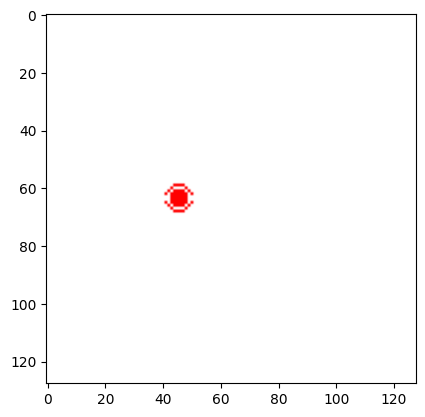

In [19]:
plt.imshow(positive.cpu()[3].moveaxis(0, -1))